# Try to do sentiment analysis using the textblob package in NLTK


In [1]:
import gzip
import json
import re
import os
from tqdm import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from textblob import TextBlob
import string
import numpy as np
from scipy.stats import entropy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
pd.options.display.float_format = '{:,}'.format

# download the NLTK stopwords and wordnet corpora
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("downloaded package wordnet")


downloaded package wordnet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# functin to load in the goodreads gzip files
# set head to take a subset of the reviews off the top
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data


In [125]:
DIR = 'data/'

reviews = load_data(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'), 30000)
reviews_df = pd.DataFrame(reviews)


In [109]:
# define a function to perform preprocessing on a single review text string with a loading bar
def preprocess_reviews(review_text):
    # define a progress bar with the total length of the review text
    #with tqdm(total=len(review_text)) as pbar:
    # convert to lowercase
    review_text = review_text.lower()
    #pbar.update(len(review_text))
    # remove punctuation
    review_text = review_text.translate(str.maketrans('', '', string.punctuation))
    #pbar.update(len(string.punctuation))
    # tokenize into words
    words = word_tokenize(review_text)
    #pbar.update(len(words))
    # remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    #pbar.update(len(stopwords.words('english')))
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    #pbar.update(len(words))
    # join the words back into a string
    review_text = ' '.join(words)
    #pbar.update(len(words))
    return review_text
# def preprocess_reviews(review_text):
#     # convert to lowercase
#     review_text = review_text.lower()
#     # remove punctuation
#     review_text = review_text.translate(str.maketrans('', '', string.punctuation))
#     # tokenize into words
#     words = word_tokenize(review_text)
#     # remove stop words
#     words = [word for word in words if word not in stopwords.words('english')]
#     # lemmatize words
#     lemmatizer = WordNetLemmatizer()
#     words = [lemmatizer.lemmatize(word) for word in words]
#     # join the words back into a string
#     review_text_processed = ' '.join(words)
#     # split review text into sentences
#     sentences = sent_tokenize(review_text)
#     # join the sentences back into a string
#     review_text_sentences = ' '.join(sentences)
#     return review_text_processed, review_text_sentences



In [126]:
# preprocess the review_text column of the DataFrame
# reviews_df['review_text_preprocessed'], reviews_df['review_text_sentences'] = zip(*reviews_df['review_text'].apply(preprocess_reviews))
reviews_df['review_text_preprocessed'] = reviews_df['review_text'].apply(preprocess_reviews)
print("reviews text preprocessed")



reviews text preprocessed


In [127]:
# add a column for review length
reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(x))

reviews_df['review_length'] = reviews_df['review_text_preprocessed'].apply(lambda x: len(x.split()))
reviews_df = reviews_df[reviews_df['review_length'] > 3]
print(len(reviews_df))

28542


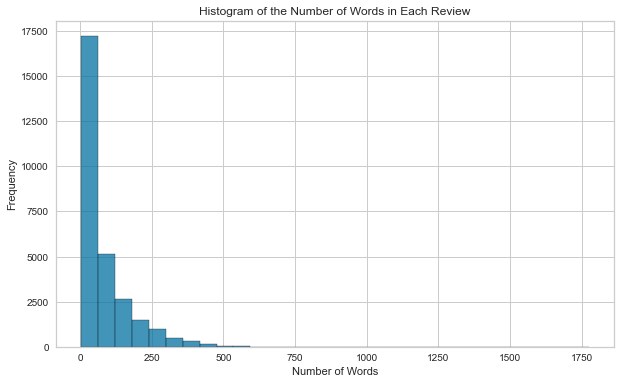

In [178]:
# Histogram of the number of words in each review
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews_df, x='review_length', bins=30)
plt.title('Histogram of the Number of Words in Each Review')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

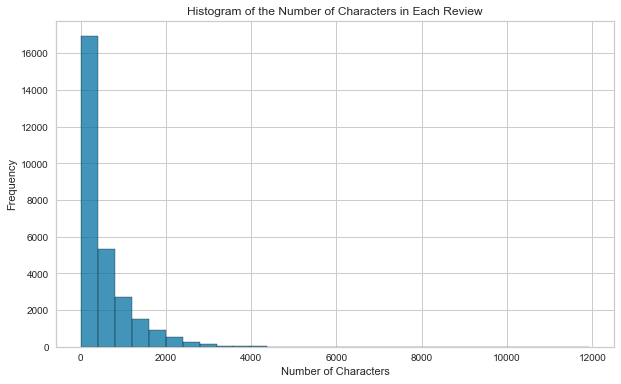

In [179]:
# Calculate the number of characters in each review
reviews_df['char_count'] = reviews_df['review_text_preprocessed'].apply(lambda x: len(x))

# Histogram of the number of characters in each review
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews_df, x='char_count', bins=30)
plt.title('Histogram of the Number of Characters in Each Review')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [159]:
# new column for full review sentiment polarity score
reviews_df['sentiment_polarity'] = 0.0

# calculate the sentiment polarity of each review using TextBlob
reviews_df['sentiment_polarity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.polarity)
# check if any NaN values were assigned to the sentiment_polarity column
if reviews_df['sentiment_polarity'].isna().sum() > 0:
    print('NaN values were assigned to the sentiment_polarity column.')
else:
    print('No NaN values were assigned to the sentiment_polarity column.')

reviews_df['subjectivity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.subjectivity if len(x.split()) >= 6 else None)

# calculate the absolute value of the sentiment polarity for each review
reviews_df['sentiment_polarity_abs'] = reviews_df['sentiment_polarity'].abs()


No NaN values were assigned to the sentiment_polarity column.


In [168]:
null_values = reviews_df['sentiment_polarity'].isnull().sum()     
print(null_values)

0


In [ ]:
# Define a function to calculate the sentiment polarity for each sentence in a review
def get_sentence_sentiment(review):
    blob = TextBlob(review)
    sentence_sentiments = []
    for sentence in blob.sentences:
        sentence_sentiments.append(sentence.sentiment.polarity)
    return sentence_sentiments

# Apply the function to each review in the reviews_df DataFrame
reviews_df['sentiment_polarity_sentence'] = reviews_df['review_text_sentences'].apply(get_sentence_sentiment)
print(reviews_df['sentiment_polarity'])





In [105]:
# trying to remove NaN rows
nan_mask = pd.isna(reviews_df['sentiment_polarity'])
reviews_df = reviews_df.dropna(subset=['sentiment_polarity'])

reviews_df = reviews_df[~nan_mask]
# select and print the NaN values in the sentiment_polarity column
print(reviews_df['sentiment_polarity'][nan_mask])

Series([], Name: sentiment_polarity, dtype: float64)


C:\Users\alexp\AppData\Local\Temp\ipykernel_15584\2924390771.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_df = reviews_df[~nan_mask]


In [161]:
def plot_sentiment_polarity(reviews_df):            
    # calculate the sentiment polarity of each review using TextBlob, and exclude reviews that are shorter than 6 words
    #reviews_df['sentiment_polarity'] = reviews_df['review_text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.polarity if len(x.split()) >= 6 else None)

    # plot the sentiment polarity distribution
    sns.displot(reviews_df['sentiment_polarity'], kde=True)
    plt.title('Sentiment Polarity Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.show()
    plt.savefig("output/sentiment_polarity_1000")

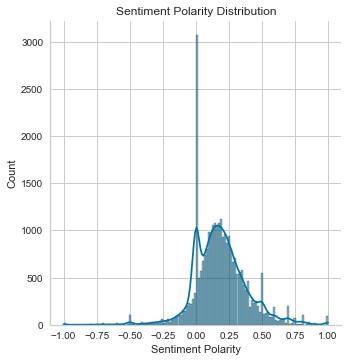

<Figure size 576x396 with 0 Axes>

In [162]:
plot_sentiment_polarity(reviews_df)

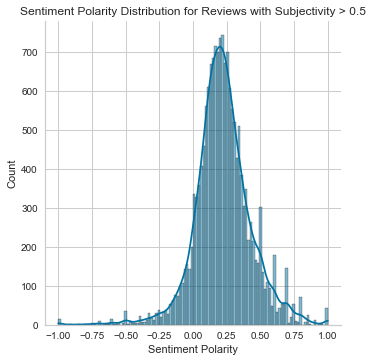

In [163]:
# plot the sentiment polarity distribution for reviews with subjectivity above 0.5
sns.displot(reviews_df[reviews_df['subjectivity'] > 0.5]['sentiment_polarity'], kde=True)
plt.title('Sentiment Polarity Distribution for Reviews with Subjectivity > 0.5')
plt.xlabel('Sentiment Polarity')
plt.show()

In [137]:
from scipy.stats import entropy as scipy_entropy

def entropy_of_distribution(values):
    # compute the probability distribution of the input values
    prob = np.histogram(values, bins='auto', density=True)[0]


In [165]:
# group the reviews by book
# grouped_df = reviews_df.groupby('book_id')

# # calculate the entropy and Gini coefficient of the sentiment polarity distribution for each book
# entropy = grouped_df.apply(lambda x: entropy_of_distribution(x['sentiment_polarity']))
# # add the entropy column to the reviews_df DataFrame
# reviews_df['sentiment_entropy'] = reviews_df['book_id'].apply(lambda x: entropy[x])


def add_sentiment_metrics(reviews_df):
    # filter out books with only one review
    reviews_df = reviews_df.groupby('book_id').filter(lambda x: len(x) > 1)

    # group the reviews by book
    grouped_df = reviews_df.groupby('book_id')

    # calculate the entropy of the sentiment polarity distribution for each book
    entropy = grouped_df['sentiment_polarity'].apply(lambda x: entropy_of_distribution(x)).reset_index(name='sentiment_entropy')

    # join the entropy columns to the reviews_df DataFrame
    reviews_df = reviews_df.merge(entropy, on='book_id')

    return reviews_df



In [166]:
reviews_df_copy = reviews_df.copy()
reviews_df_copy = add_sentiment_metrics(reviews_df_copy)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_text_preprocessed,review_length,sentiment_polarity,subjectivity,sentiment_polarity_abs,reviewer_label,sentiment_entropy
0,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,,,1,0,recommended katz avail free december httpwwwau...,6,0.4,0.8,0.4,long_librarian,None
1,098538b422348d74ac67cbd95fd536e6,16981,1b8f30b7fa7077f0323c007351850598,5,"I started to read it in December last year, bu...",Sun Nov 09 18:11:19 -0800 2014,Mon Mar 30 16:52:12 -0700 2015,Sun Mar 29 00:00:00 -0700 2015,Sun Nov 09 00:00:00 -0800 2014,16,13,started read december last year eventually fou...,442,0.06277151211361738,0.4758458646616543,0.06277151211361738,long_librarian,None
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,fun fast paced science fiction thriller read 2...,236,0.19049422799422797,0.6005759121830548,0.19049422799422797,long_librarian,None
3,01ec1a320ffded6b2dd47833f2c8e4fb,28684704,31db9238ec11ca671a65a50643f952b7,5,"Mind-bending and completely unique, take a cha...",Sun Aug 28 20:43:49 -0700 2016,Sat Sep 03 06:59:39 -0700 2016,Tue Aug 30 00:00:00 -0700 2016,Sun Aug 28 00:00:00 -0700 2016,13,0,mindbending completely unique take chance read...,179,0.16544312169312167,0.5488425925925925,0.16544312169312167,long_librarian,None
4,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,,,5,1,recommended reading understand going middle am...,11,0.25,0.25,0.25,long_librarian,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8414,ab2fadb5c7bbe55c80406d2b3692e969,17265216,598c3e2fabafebb86a5e5c1e45775f26,4,3rd&up \n How did I not know that this graphic...,Sat Oct 04 12:38:42 -0700 2014,Sat Oct 04 12:48:28 -0700 2014,Sun Sep 28 00:00:00 -0700 2014,,0,0,3rdup know graphic novel existed much fun surv...,39,0.18125000000000002,0.525,0.18125000000000002,short_librarian,None
8415,5357ea0022472e12d65449f9e92eb2d4,17797381,d3a202b3e69fe2f245bb74fe3c822914,4,While this includes many of the characteristic...,Thu Dec 26 06:12:39 -0800 2013,Mon Apr 21 09:03:07 -0700 2014,Sat Apr 19 00:00:00 -0700 2014,Tue Apr 15 00:00:00 -0700 2014,0,0,includes many characteristic koontz novel dog ...,59,0.03492063492063492,0.4841269841269842,0.03492063492063492,short_librarian,None
8416,ab2fadb5c7bbe55c80406d2b3692e969,17797381,a25f6cc1abe5bc0120692ceb0c9a7d90,3,"In Koontz's latest thriller, two lost souls wi...",Wed Jan 15 15:36:37 -0800 2014,Wed Jan 15 16:27:33 -0800 2014,Fri Jan 10 00:00:00 -0800 2014,,1,0,koontzs latest thriller two lost soul history ...,77,0.06178571428571429,0.6192857142857144,0.06178571428571429,short_librarian,None
8417,ab2fadb5c7bbe55c80406d2b3692e969,6654313,716c60ab709b878caaa62539be93c4b8,3,"3.5 stars, 9th&up \n The starcrossed saga of S...",Sat Jul 12 12:51:41 -0700 2014,Sat Jul 12 12:57:45 -0700 2014,Sun Jul 06 00:00:00 -0700 2014,,0,0,35 star 9thup starcrossed saga sam former were...,41,0.0,0.15,0.0,short_librarian,None


In [169]:
import seaborn as sns

# plot the distribution of entropy for all reviews
sns.displot(reviews_df['sentiment_entropy'], kde=True)
plt.title('Distribution of Sentiment Entropy for All Reviews')
plt.xlabel('Sentiment Entropy')
plt.show()

KeyError: 'sentiment_entropy'

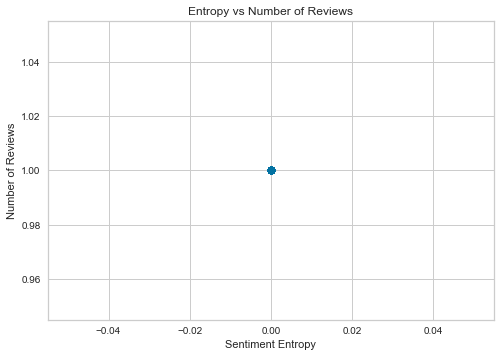

In [103]:
# group reviews by book and compute entropy and number of reviews
book_df = reviews_df.groupby('book_id').agg({'sentiment_entropy': 'mean', 'review_id': 'count'})

# plot entropy vs number of reviews
plt.scatter(book_df['sentiment_entropy'], book_df['review_id'])
plt.title('Entropy vs Number of Reviews')
plt.xlabel('Sentiment Entropy')
plt.ylabel('Number of Reviews')
plt.show()

In [102]:
high_entropy_books = book_df[book_df['sentiment_entropy'] > 1.5]
# filter reviews to only include high-entropy books
high_entropy_reviews = reviews_df[reviews_df['book_id'].isin(high_entropy_books.index)]

# plot histogram of sentiment polarity scores
plt.hist(high_entropy_reviews['sentiment_polarity'], bins=20)
plt.title('Sentiment Polarity Distribution for High-Entropy Books')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


NameError: name 'book_df' is not defined

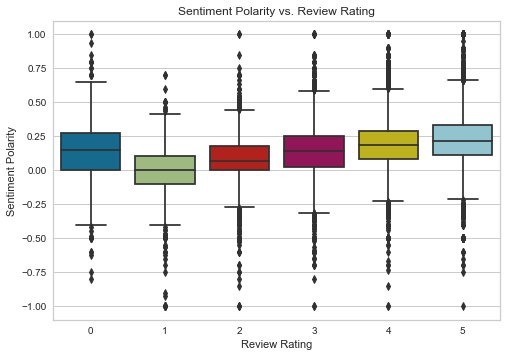

In [140]:
#sentiment vs book rating
sns.boxplot(x='rating', y='sentiment_polarity', data=reviews_df)
plt.title('Sentiment Polarity vs. Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('Sentiment Polarity')
plt.show()

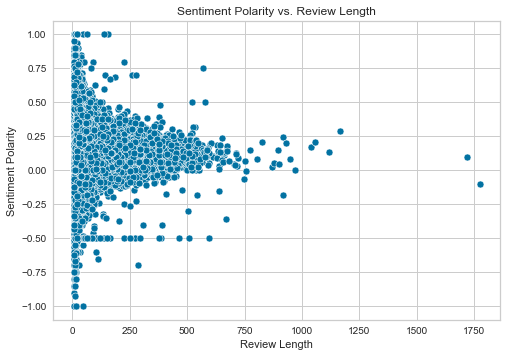

In [141]:
sns.scatterplot(x='review_length', y='sentiment_polarity', data=reviews_df)
plt.title('Sentiment Polarity vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Polarity')
plt.show()

# Clustering of user role analysis
First we define our feature set, and group by user averages for those features.

In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA

In [143]:
# Group the reviews_df by user_id and calculate summary statistics
user_grouped = reviews_df.groupby('user_id').agg({
    'book_id': 'count',                     # Number of reviews written by each user
    'rating': 'mean',                       # Average rating given by each user
    'review_length': 'mean',                # Average length of each user's reviews
    'sentiment_polarity': [np.mean, np.std] # Mean and standard deviation of sentiment polarity for each user
})

# Flatten the column names
user_grouped.columns = ['_'.join(col).strip() for col in user_grouped.columns.values]

# Rename the columns to more intuitive names
user_grouped = user_grouped.rename(columns={
    'book_id_count': 'num_reviews',
    'rating_mean': 'avg_rating',
    'review_length_mean': 'avg_review_length',
    'sentiment_polarity_mean': 'avg_sentiment_polarity',
    'sentiment_polarity_std': 'std_sentiment_polarity'
})

# drop any rows with missing values
user_grouped.dropna(inplace=True)

# Normalize the features in user_grouped
scaler = StandardScaler()
X = scaler.fit_transform(user_grouped.values)

# Convert the normalized features back to a DataFrame
user_normalized = pd.DataFrame(X, index=user_grouped.index, columns=user_grouped.columns)


In [144]:
# Apply KMeans clustering to the normalized features
# retroactively change this according to elbow plot output -> 4
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
user_clustered = kmeans.fit_predict(user_normalized)

In [32]:
user_grouped = reviews_df.groupby('user_id').agg({
    'book_id': 'count',                     # Number of reviews written by each user
    'rating': 'mean',                       # Average rating given by each user
    'review_length': 'mean',                # Average length of each user's reviews
    'sentiment_polarity': [np.mean, np.std] # Mean and standard deviation of sentiment polarity for each user
})

# drop any rows with missing values
user_grouped_2 = user_grouped.dropna()

# count number of rows dropped
num_dropped = len(user_grouped) - len(user_grouped_2)
print(f"Dropped {num_dropped} rows with missing values")
print(user_grouped_2.shape)

Dropped 111 rows with missing values
(495, 5)


In [28]:
def evaluate_kmeans(X, k_range):
    """
    Perform KMeans clustering on the given data with the provided k range and
    evaluate performance using silhouette score, elbow plot, and 2D visualization.
    
    Parameters:
        X (ndarray): Array of features to cluster on.
        k_range (tuple): Tuple of integers representing the range of k values to test.
        
    Returns:
        None
    """
    # Create KMeans model
    kmeans = KMeans(random_state=0)

    # Create elbow plot to determine optimal k
    elbow_plot = KElbowVisualizer(kmeans, k=k_range)
    elbow_plot.fit(X)
    plt.show()

    # Determine optimal k
    optimal_k = elbow_plot.elbow_value_

    # Create silhouette plot
    silhouette_plot = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    silhouette_plot.fit(X)
    plt.show()

    # Compute silhouette score
    silhouette_score_val = silhouette_score(X, kmeans.labels_)

    # Print evaluation metrics
    print(f'Optimal k: {optimal_k}')
    print(f'Silhouette score: {silhouette_score_val}')

    # Perform dimensionality reduction
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Create 2D plot of clusters
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_)
    plt.show()

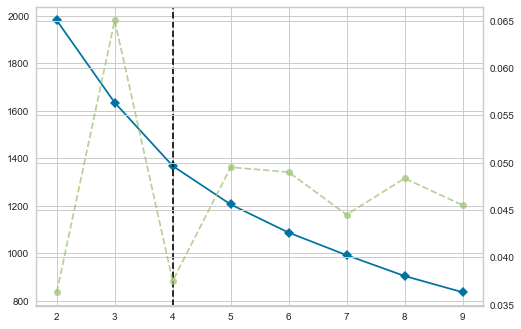

c:\Users\alexp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


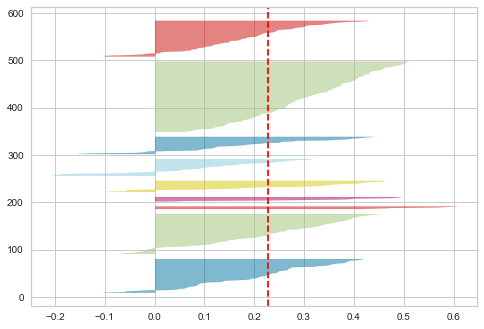

Optimal k: 4
Silhouette score: 0.22771814669311358


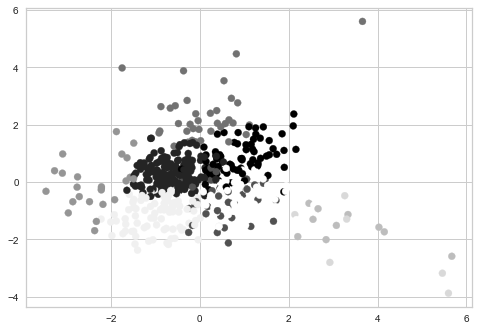

In [29]:
evaluate_kmeans(user_normalized, range(2, 10))


In [30]:
# Get feature names from the user_df
feature_names = user_grouped.columns[1:]

# Print top 5 features with highest weights for each cluster
for i in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    feature_weights = dict(zip(feature_names, cluster_center))
    sorted_features = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
    top_features = [f[0] for f in sorted_features[:5]]
    print(f"Cluster {i+1}: {top_features}")


Cluster 1: ['avg_rating', 'avg_sentiment_polarity', 'avg_review_length', 'std_sentiment_polarity']
Cluster 2: ['std_sentiment_polarity', 'avg_review_length', 'avg_rating', 'avg_sentiment_polarity']
Cluster 3: ['avg_rating', 'avg_sentiment_polarity', 'std_sentiment_polarity', 'avg_review_length']
Cluster 4: ['avg_sentiment_polarity', 'avg_review_length', 'avg_rating', 'std_sentiment_polarity']


In [31]:
user_grouped['cluster'] = user_clustered

review_counts = user_grouped.groupby(['cluster', 'user_id'])['num_reviews'].count()

review_count_distribution = review_counts.groupby('cluster').value_counts()

review_count_distribution.head()

# import seaborn as sns

# sns.histplot(x=review_counts, hue='cluster', multiple='stack', bins=30)


cluster  num_reviews
0        1                6
1        1              225
2        1              144
3        1              120
Name: num_reviews, dtype: int64

# Supervised appraoch to reviewer labeling
We first need to engineer labels on part of our data for the model to train off of. Then we need to feed in the unlabeled test data and see how well it does.



In [175]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [145]:
books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'), 1000000) 

books_df = pd.DataFrame(books)

print(books_df['authors'].head())

# Get the list of book IDs that belong to authors
author_books = books_df[books_df['authors'].notnull()]['book_id']

# Create a set to store the author IDs
author_ids = set()

# Loop over each row in the books_df
for _, row in books_df.iterrows():
    # Get the list of authors for this book
    authors = row['authors']
    # Loop over each author in the list
    for author in authors:
        # Extract the author ID from the dictionary
        author_id = author['author_id']
        # Add the author ID to the set
        author_ids.add(author_id)

#print(author_ids)



0    [{'author_id': '604031', 'role': ''}]
1    [{'author_id': '626222', 'role': ''}]
2     [{'author_id': '10333', 'role': ''}]
3      [{'author_id': '9212', 'role': ''}]
4    [{'author_id': '149918', 'role': ''}]
Name: authors, dtype: object


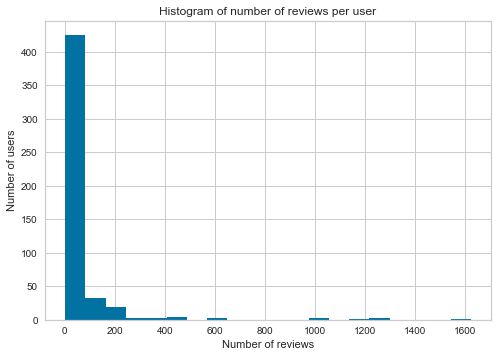

In [151]:
user_grouped
# Create a histogram of the number of reviews written by each user
plt.hist(user_grouped['num_reviews'], bins=20)

# Add labels and title
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.title('Histogram of number of reviews per user')

# Show the plot
plt.show()

In [170]:
# Create a new column to store the reviewer label
reviews_df['reviewer_label'] = ''


# Calculate the overall mean review length
overall_mean_review_length = reviews_df['review_length'].mean()

# Iterate over each user and assign the appropriate label
for user_id, num_reviews in user_grouped.iterrows():
    user_reviews = reviews_df.loc[reviews_df['user_id'] == user_id]
    avg_review_length = user_reviews['review_length'].mean()
    
    if user_id in authors:
        reviews_df.loc[reviews_df['user_id'] == user_id, 'reviewer_label'] = 'author'
    elif num_reviews['num_reviews'] >= 40:
        if avg_review_length > overall_mean_review_length:
            reviews_df.loc[reviews_df['user_id'] == user_id, 'reviewer_label'] = 'long_librarian'
        else:
            reviews_df.loc[reviews_df['user_id'] == user_id, 'reviewer_label'] = 'short_librarian'
    else:
        if avg_review_length > overall_mean_review_length:
            reviews_df.loc[reviews_df['user_id'] == user_id, 'reviewer_label'] = 'long_common_user'
        else:
            reviews_df.loc[reviews_df['user_id'] == user_id, 'reviewer_label'] = 'short_common_user'



In [171]:
print(reviews_df[reviews_df['reviewer_label']=='long_common_user']['review_id'].count())

619


In [172]:
null_values = reviews_df['sentiment_polarity'].isnull().sum()     
print(null_values)


0


In [173]:
# Create a new DataFrame with the reviewer roles and other features
features_df = reviews_df[['rating', 'review_length', 'sentiment_polarity', 'reviewer_label']].copy()

# # # Check for missing values in the features
# if features_df.isnull().values.any():
#     raise ValueError("Missing values found in features")

# Check for missing values in the labels
if reviews_df['sentiment_polarity'].isnull().values.any():
    raise ValueError("Missing values found in labels")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df.drop(columns=['reviewer_label']), features_df['reviewer_label'], test_size=0.2, random_state=0)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5857418111753372


C:\Users\alexp\AppData\Local\Temp\ipykernel_15584\3913556723.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


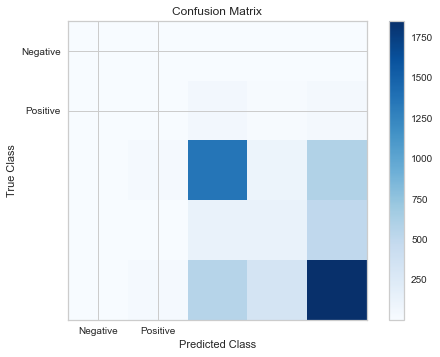

In [177]:
# get predicted probabilities for the test set
y_pred_proba = clf.predict_proba(X_test)[:,1]

# # calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# # calculate the area under the ROC curve
# roc_auc = auc(fpr, tpr)

# # plot the ROC curve
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

# # get predicted classes for the test set
# y_pred = rf_model.predict(X_test)

# create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix as a heatmap
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['Negative', 'Positive'])
plt.yticks([0,1], ['Negative', 'Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# TODO
Review sentence level sentiment. sentences currently aren't preprocessed correctly.
Rerun analysis with as much of the full data as possible. Currently, I use 30000 reviews and 100000 books.

Add subjectivity to the reviewer labeling approaches.

Interpret the clustering done by the k-means.

Run the random forest and make sure that NaN aren't an issue in prediction.

Recommmender system?

Fix entropy, or jsut use the entropy for smaller amount of reviews (10000)

Pick out specific reviews of high entropy books?

statistics about by subset of 30000 reviews.
